<a href="https://colab.research.google.com/github/Kussil/Financial_Sentiment_LLM/blob/main/04_Stock_Modeling/Aggregated_Stock_Data/Llama_Prompt/Stock_Modeling_Llama_prompt_ALL_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Modeling using Gemini Sentiments with Prompt 2: All



In [1]:
#install dependencies
!pip install -q ipympl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.9 MB/s eta 0:00:00


In [2]:
# import libraries
import os
from google.colab import userdata
from google.colab import output
import pandas as pd
import yfinance as yf
import textwrap
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
import pytz
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
output.enable_custom_widget_manager()

In [3]:
#Delete repo clone if needed
!rm -rf /content/CVX_Rice_project/

In [4]:
# Import github token with google secrets thingy and clone git repository
GITHUB_TOKEN = userdata.get('github')
os.environ['GITHUB_TOKEN'] = GITHUB_TOKEN
!git clone https://{GITHUB_TOKEN}@github.com/Kussil/Financial_Sentiment_LLM.git

Cloning into 'Financial_Sentiment_LLM'...
remote: Enumerating objects: 3135, done.
remote: Counting objects: 100% (701/701), done.
remote: Compressing objects: 100% (361/361), done.
remote: Total 3135 (delta 411), reused 588 (delta 336), pack-reused 2434
Receiving objects: 100% (3135/3135), 526.74 MiB | 25.02 MiB/s, done.
Resolving deltas: 100% (2043/2043), done.
Updating files: 100% (1225/1225), done.


In [13]:
# Read in outputs from Gemini Sentiment Analysis
Llama_sentiment = pd.read_csv('/content/Financial_Sentiment_LLM/03_Sentiment_Analysis/LLama/Llama_data_for_stock_modeling.csv')
Llama_sentiment = Llama_sentiment.fillna('')
Llama_sentiment

,Source,Unique_ID,Ticker,Date,URL,Finance,Production,Reserves/M&A,Regulatory,Green Energy,OG Price
0,Investment Research,IR-1,MRO,2024-05-16,,Neutral,Positive,Neutral,Neutral,Neutral,Neutral
1,Investment Research,IR-2,EOG,2024-05-14,,Positive,Neutral,Neutral,Neutral,Negative,Neutral
2,Investment Research,IR-3,EOG,2024-05-11,,Positive,Neutral,Positive,Negative,Neutral,Positive
3,Investment Research,IR-4,DVN,2024-05-11,,Neutral,Negative,Neutral,Neutral,Negative,Negative
4,Investment Research,IR-5,COP,2024-05-07,,Neutral,Positive,Neutral,Negative,Neutral,Positive
...,...,...,...,...,...,...,...,...,...,...,...
10120,Earnings Call Q&A,EQ-338,XOM,2021-02-02,,Neutral,Positive,Neutral,Neutral,Positive,Neutral
10121,Earnings Call Q&A,EQ-339,COP,2021-02-02,,Negative,Negative,Negative,Negative,Negative,Negative
10122,Earnings Call Q&A,EQ-340,EOG,2019-05-03,,Neutral,Positive,Positive,Neutral,Neutral,Neutral
10123,Earnings Call Q&A,EQ-341,SHEL,2019-05-02,,Negative,Negative,Negative,Negative,Negative,Negative


In [14]:
source_values = Llama_sentiment["Source"].unique()
source_values


array(['Investment Research', 'ProQuest', 'SEC Filings',
       'Earnings Call Presentations', 'Earnings Call Q&A'], dtype=object)

In [16]:
# Define a list of date formats
date_formats = [
    '%d/%m/%Y',  # 01/01/2021
    '%m/%d/%Y',  # 5/16/2024
    '%Y-%m-%d',  # 2021-02-28
    '%B %d, %Y',  # March 15, 2021
    '%b-%d-%Y',  # Apr-30-2019
    '%Y.%m.%d',  # 2021.04.10
    '%m-%d-%Y',  # 04-10-2021
    '%d-%b-%y',  # 17-Aug-22
    '%b-%y'  # Sep-19
]

# Function to parse dates with multiple formats
def parse_date(date_str):
    for fmt in date_formats:
        try:
            # Handle special case where only month and year are given
            if fmt == '%b-%y':
                parsed_date = datetime.strptime(date_str, fmt)
                # Default to the first day of the month
                return parsed_date.replace(day=1)
            return datetime.strptime(date_str, fmt)
        except ValueError:
            continue
    raise ValueError(f"Date format not recognized: {date_str}")


# Apply the function to the 'Date' column
Llama_sentiment['Date'] = Llama_sentiment['Date'].apply(parse_date)

# Format the dates in a specific string format
Llama_sentiment['Date'] = Llama_sentiment['Date'].dt.strftime('%Y-%m-%d')

# Modifying the original dataframe to only include rows where the source is "Earnings Call Presentations" or "Earnings Call Q&A"
#gemini_prompt2_sentiment = gemini_prompt2_sentiment[gemini_prompt2_sentiment["Source"] == "SEC Filings"]

# Display the DataFrame
Llama_sentiment

,Source,Unique_ID,Ticker,Date,URL,Finance,Production,Reserves/M&A,Regulatory,Green Energy,OG Price
0,Investment Research,IR-1,MRO,2024-05-16,,Neutral,Positive,Neutral,Neutral,Neutral,Neutral
1,Investment Research,IR-2,EOG,2024-05-14,,Positive,Neutral,Neutral,Neutral,Negative,Neutral
2,Investment Research,IR-3,EOG,2024-05-11,,Positive,Neutral,Positive,Negative,Neutral,Positive
3,Investment Research,IR-4,DVN,2024-05-11,,Neutral,Negative,Neutral,Neutral,Negative,Negative
4,Investment Research,IR-5,COP,2024-05-07,,Neutral,Positive,Neutral,Negative,Neutral,Positive
...,...,...,...,...,...,...,...,...,...,...,...
10120,Earnings Call Q&A,EQ-338,XOM,2021-02-02,,Neutral,Positive,Neutral,Neutral,Positive,Neutral
10121,Earnings Call Q&A,EQ-339,COP,2021-02-02,,Negative,Negative,Negative,Negative,Negative,Negative
10122,Earnings Call Q&A,EQ-340,EOG,2019-05-03,,Neutral,Positive,Positive,Neutral,Neutral,Neutral
10123,Earnings Call Q&A,EQ-341,SHEL,2019-05-02,,Negative,Negative,Negative,Negative,Negative,Negative


In [17]:
# Renaming the columns to simplify sentiment categories
Llama_sentiment.rename(columns={
    'Reserves / Exploration / Acquisitions / Mergers / Divestments': 'Reserves/M&A',
    'Environment / Regulatory / Geopolitics': 'Regulatory',
    'Alternative Energy / Lower Carbon': 'Green Energy',
    'Oil Price / Natural Gas Price / Gasoline Price': 'OG Price'
}, inplace=True)

Llama_sentiment

,Source,Unique_ID,Ticker,Date,URL,Finance,Production,Reserves/M&A,Regulatory,Green Energy,OG Price
0,Investment Research,IR-1,MRO,2024-05-16,,Neutral,Positive,Neutral,Neutral,Neutral,Neutral
1,Investment Research,IR-2,EOG,2024-05-14,,Positive,Neutral,Neutral,Neutral,Negative,Neutral
2,Investment Research,IR-3,EOG,2024-05-11,,Positive,Neutral,Positive,Negative,Neutral,Positive
3,Investment Research,IR-4,DVN,2024-05-11,,Neutral,Negative,Neutral,Neutral,Negative,Negative
4,Investment Research,IR-5,COP,2024-05-07,,Neutral,Positive,Neutral,Negative,Neutral,Positive
...,...,...,...,...,...,...,...,...,...,...,...
10120,Earnings Call Q&A,EQ-338,XOM,2021-02-02,,Neutral,Positive,Neutral,Neutral,Positive,Neutral
10121,Earnings Call Q&A,EQ-339,COP,2021-02-02,,Negative,Negative,Negative,Negative,Negative,Negative
10122,Earnings Call Q&A,EQ-340,EOG,2019-05-03,,Neutral,Positive,Positive,Neutral,Neutral,Neutral
10123,Earnings Call Q&A,EQ-341,SHEL,2019-05-02,,Negative,Negative,Negative,Negative,Negative,Negative


In [18]:
#Create Positive and Negative Ratios for each row

# Columns to consider for calculating ratios
columns_to_check = ['Finance', 'Production', 'Reserves/M&A', 'Regulatory', 'Green Energy', 'OG Price']

# Function to calculate positive and negative ratios
def calculate_ratios(row):
    positive_count = (row[columns_to_check] == 'Positive').sum()
    negative_count = (row[columns_to_check] == 'Negative').sum()
    neutral_count = (row[columns_to_check] == 'Neutral').sum()
    total_count = len(columns_to_check)
    pos_ratio = positive_count / total_count
    neg_ratio = negative_count / total_count
    neu_ratio = neutral_count / total_count
    return pd.Series([pos_ratio, neg_ratio, neu_ratio], index=['Pos_Ratio', 'Neg_Ratio', 'Neu_Ratio'])

# Apply the function to each row
Llama_sentiment[['Pos_Ratio', 'Neg_Ratio', 'Neu_Ratio']] = Llama_sentiment.apply(calculate_ratios, axis=1)

# Replace senitment category values with binary equivalents
binary_mapping = {'Positive': 1, 'Negative': -1, 'Neutral': 0}
Llama_sentiment[columns_to_check] = Llama_sentiment[columns_to_check].replace(binary_mapping)

Llama_sentiment

,Source,Unique_ID,Ticker,Date,URL,Finance,Production,Reserves/M&A,Regulatory,Green Energy,OG Price,Pos_Ratio,Neg_Ratio,Neu_Ratio
0,Investment Research,IR-1,MRO,2024-05-16,,0,1,0,0,0,0,0.166667,0.000000,0.833333
1,Investment Research,IR-2,EOG,2024-05-14,,1,0,0,0,-1,0,0.166667,0.166667,0.666667
2,Investment Research,IR-3,EOG,2024-05-11,,1,0,1,-1,0,1,0.500000,0.166667,0.333333
3,Investment Research,IR-4,DVN,2024-05-11,,0,-1,0,0,-1,-1,0.000000,0.500000,0.500000
4,Investment Research,IR-5,COP,2024-05-07,,0,1,0,-1,0,1,0.333333,0.166667,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10120,Earnings Call Q&A,EQ-338,XOM,2021-02-02,,0,1,0,0,1,0,0.333333,0.000000,0.666667
10121,Earnings Call Q&A,EQ-339,COP,2021-02-02,,-1,-1,-1,-1,-1,-1,0.000000,1.000000,0.000000
10122,Earnings Call Q&A,EQ-340,EOG,2019-05-03,,0,1,1,0,0,0,0.333333,0.000000,0.666667
10123,Earnings Call Q&A,EQ-341,SHEL,2019-05-02,,-1,-1,-1,-1,-1,-1,0.000000,1.000000,0.000000


In [19]:
#Identify minimum article date for stock price download
min_date = Llama_sentiment['Date'].min()
min_date

'2019-01-07'

In [20]:
ticker_list = Llama_sentiment['Ticker'].unique().tolist()
ticker_list

['MRO',
 'EOG',
 'DVN',
 'COP',
 'PXD',
 'PDCE',
 'CXO',
 'CVX',
 'MPC',
 'HES',
 'PSX',
 'XOM',
 'SHEL',
 'BP',
 'OXY',
 'VLO',
 'TTE',
 'EQNR']

In [21]:
#Pull YahooFinance stock data to get Returns (ret)
all_data = {}

for ticker in ticker_list:
    try:
        # Get the last date for the current ticker from gemini_prompt1_sentiment
        last_date = Llama_sentiment[Llama_sentiment['Ticker'] == ticker]['Date'].max()
        if pd.isna(last_date):
            print(f"No data available for {ticker} in gemini_prompt1_sentiment.")
            continue

        # Ensure the date is in the correct format
        last_date = pd.to_datetime(last_date).strftime('%Y-%m-%d')
        print(f"Downloading data for {ticker} from {min_date} to {last_date}")

        # Download stock data
        data = yf.download(ticker, start=min_date, end=last_date)["Adj Close"]

        if data.empty:
            print(f"No data retrieved for {ticker}")
        else:
            all_data[ticker] = data

    except Exception as e:
        print(f"Error downloading data for {ticker}: {e}")

# Combine all data into a single DataFrame
if all_data:
    price_df = pd.DataFrame(all_data)
    ret_df = price_df.pct_change().dropna()
    ret_df.name = "ret"
    ret_df.describe()
else:
    print("No data available.")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['PXD']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['PDCE']: YFInvalidPeriodError("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")


No data retrieved for PXD
No data retrieved for PDCE


[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['CXO']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


No data retrieved for CXO


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [22]:
ret_df.describe()

,MRO,EOG,DVN,COP,CVX,MPC,HES,PSX,XOM,SHEL,BP,OXY,VLO,TTE,EQNR
count,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000
mean,0.001113,0.000818,0.001389,0.000992,0.000696,0.001332,0.001405,0.000844,0.000791,0.000575,0.000433,0.000883,0.001177,0.000674,0.000711
std,0.036132,0.029489,0.036448,0.027316,0.021714,0.029227,0.030540,0.025946,0.020974,0.022666,0.022967,0.038527,0.029712,0.021057,0.023944
min,-0.468521,-0.320072,-0.373972,-0.248401,-0.221248,-0.270089,-0.336685,-0.158658,-0.122248,-0.171722,-0.191040,-0.520138,-0.192209,-0.178209,-0.210562
25%,-0.017074,-0.014106,-0.016666,-0.011746,-0.008418,-0.012158,-0.014324,-0.010620,-0.010156,-0.009652,-0.010054,-0.014985,-0.012676,-0.009622,-0.011592
50%,0.000642,-0.000133,0.000569,0.000000,0.000733,0.001711,0.001130,0.000731,0.000388,0.000399,0.000000,0.000000,0.000464,0.001223,0.000000
75%,0.017404,0.014872,0.017769,0.014071,0.009541,0.015112,0.015564,0.013697,0.011249,0.010831,0.009810,0.015092,0.015847,0.010395,0.013550
max,0.232446,0.165703,0.210721,0.252139,0.227407,0.206286,0.203153,0.221722,0.126868,0.196794,0.216053,0.336977,0.312026,0.152756,0.133043


In [25]:
# Convert columns to numeric, forcing errors to NaN
df_sentiment['Finance'] = pd.to_numeric(df_sentiment['Finance'], errors='coerce')
df_sentiment['Production'] = pd.to_numeric(df_sentiment['Production'], errors='coerce')
df_sentiment['Reserves/M&A'] = pd.to_numeric(df_sentiment['Reserves/M&A'], errors='coerce')
df_sentiment['Regulatory'] = pd.to_numeric(df_sentiment['Regulatory'], errors='coerce')
df_sentiment['Green Energy'] = pd.to_numeric(df_sentiment['Green Energy'], errors='coerce')
df_sentiment['OG Price'] = pd.to_numeric(df_sentiment['OG Price'], errors='coerce')
# Check for non-numeric values
print(df_sentiment[['Finance', 'Production', 'Reserves/M&A', 'Regulatory', 'Green Energy', 'OG Price']].applymap(type).nunique())


Finance         1
Production      1
Reserves/M&A    1
Regulatory      1
Green Energy    1
OG Price        1
dtype: int64


In [26]:
# Test aggregation with a subset of data
test_group = df_sentiment[['Ticker', 'Date', 'Finance']].groupby(['Ticker', 'Date']).agg(Finance=('Finance', 'sum'))
print(test_group.head())


                   Finance
Ticker Date               
BP     2019-02-05     -2.0
       2019-02-20      0.0
       2019-04-30     -1.0
       2019-05-06      0.0
       2019-05-22      0.0


In [27]:
# Convert columns to numeric types
df_sentiment['Finance'] = pd.to_numeric(df_sentiment['Finance'], errors='coerce')
df_sentiment['Production'] = pd.to_numeric(df_sentiment['Production'], errors='coerce')
df_sentiment['Reserves/M&A'] = pd.to_numeric(df_sentiment['Reserves/M&A'], errors='coerce')
df_sentiment['Regulatory'] = pd.to_numeric(df_sentiment['Regulatory'], errors='coerce')
df_sentiment['Green Energy'] = pd.to_numeric(df_sentiment['Green Energy'], errors='coerce')
df_sentiment['OG Price'] = pd.to_numeric(df_sentiment['OG Price'], errors='coerce')

# Recalculate the ratios if necessary
df_sentiment[['Pos_Ratio2', 'Neg_Ratio2', 'Neu_Ratio2']] = df_sentiment.apply(calculate_ratios2, axis=1)

# Aggregate by ticker and date
df_grouped = df_sentiment.groupby(['Ticker', 'Date']).agg(
    article_count=('Unique_ID', 'size'),
    Finance=('Finance', 'sum'),
    Production=('Production', 'sum'),
    Reserves_MA=('Reserves/M&A', 'sum'),
    Regulatory=('Regulatory', 'sum'),
    Green_Energy=('Green Energy', 'sum'),
    OG_Price=('OG Price', 'sum'),
    Neu_ratio_avg=('Neu_Ratio2', 'mean'),
    Pos_ratio_avg=('Pos_Ratio2', 'mean'),
    Neg_ratio_avg=('Neg_Ratio2', 'mean')
).reset_index()

# Adding Date String column
df_grouped['Date String'] = df_grouped['Date'].astype(str)

# Reshape ret same day
ret_stack = ret_df.stack().reset_index()
ret_stack.columns = ['Date', 'Ticker', 'Returns']
ret_stack['Date'] = pd.to_datetime(ret_stack['Date'], format='mixed')
ret_stack['Date'] = pd.to_datetime(ret_stack['Date']).dt.date
ret_stack['Date String'] = ret_stack['Date'].astype(str)
ret_stack.drop(columns=['Date'], inplace=True)

# Merge in returns for the day from YahooFinance
df_merged = pd.merge(df_grouped, ret_stack, on=['Ticker', 'Date String'], how='left')
df_merged.drop(columns=['Date String'], inplace=True)
df_merged = df_merged.sort_values(['Ticker', 'Date'])

# Fill NaN values with the next day's value within the same 'Ticker'
df_merged['Returns (no NaN)'] = df_merged.groupby('Ticker')['Returns'].fillna(method='bfill')
df_merged['Returns Next Day'] = df_merged.groupby('Ticker')['Returns'].shift(-1)
df_merged['Returns Next Day(no NaN)'] = df_merged.groupby('Ticker')['Returns Next Day'].fillna(method='bfill')
df_merged['Returns Next Day(no NaN)'] = df_merged['Returns Next Day(no NaN)'].fillna(df_merged['Returns (no NaN)'])
df_merged


,Ticker,Date,article_count,Finance,Production,Reserves_MA,Regulatory,Green_Energy,OG_Price,Neu_ratio_avg,Pos_ratio_avg,Neg_ratio_avg,Returns,Returns (no NaN),Returns Next Day,Returns Next Day(no NaN)
0,BP,2019-02-05,2,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,0.000000,0.000000,1.000000,0.034549,0.034549,0.002360,0.002360
1,BP,2019-02-20,1,0.0,0.0,0.0,-1.0,0.0,0.0,0.833333,0.000000,0.166667,0.002360,0.002360,0.016504,0.016504
2,BP,2019-04-30,2,-1.0,0.0,-1.0,0.0,0.0,-1.0,0.250000,0.250000,0.500000,0.016504,0.016504,-0.003482,-0.003482
3,BP,2019-05-06,1,0.0,0.0,0.0,-1.0,1.0,0.0,0.666667,0.166667,0.166667,-0.003482,-0.003482,-0.009591,-0.009591
4,BP,2019-05-22,2,0.0,0.0,0.0,2.0,0.0,0.0,0.666667,0.250000,0.083333,-0.009591,-0.009591,-0.023618,-0.023618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7516,XOM,2024-05-07,1,0.0,-1.0,0.0,-1.0,-1.0,-1.0,0.333333,0.000000,0.666667,-0.004968,-0.004968,0.019716,0.019716
7517,XOM,2024-05-09,1,0.0,-1.0,0.0,-1.0,0.0,0.0,0.666667,0.000000,0.333333,0.019716,0.019716,-0.004053,-0.004053
7518,XOM,2024-05-10,3,0.0,-1.0,1.0,-2.0,1.0,0.0,0.722222,0.111111,0.166667,-0.004053,-0.004053,NaN,0.000000
7519,XOM,2024-05-11,1,0.0,0.0,0.0,0.0,1.0,0.0,0.833333,0.166667,0.000000,NaN,0.000000,0.000000,0.000000


In [23]:
# add overall article sentiment
df_sentiment = Llama_sentiment

# Function to calculate positive and negative ratios
def calculate_ratios2(row):
    positive_count = (row[columns_to_check] == 1).sum()
    negative_count = (row[columns_to_check] == -1).sum()
    neutral_count = (row[columns_to_check] == 0).sum()
    total_count = len(columns_to_check)
    pos_ratio = positive_count / total_count
    neg_ratio = negative_count / total_count
    neu_ratio = neutral_count / total_count
    return pd.Series([pos_ratio, neg_ratio, neu_ratio], index=['Pos_Ratio2', 'Neg_Ratio2', 'Neu_Ratio2'])

# Apply the function to each row
df_sentiment[['Pos_Ratio2', 'Neg_Ratio2', 'Neu_Ratio2']] = df_sentiment.apply(calculate_ratios2, axis=1)


# aggregate by ticker and date
df_grouped = df_sentiment.groupby(['Ticker', 'Date']).agg(
    article_count=('Unique_ID', 'size'),
    Finance=('Finance', 'sum'),
    Production=('Production', 'sum'),
    Reserves_MA=('Reserves/M&A', 'sum'),
    Regulatory=('Regulatory', 'sum'),
    Green_Energy=('Green Energy', 'sum'),
    OG_Price=('OG Price', 'sum'),
    Neu_ratio_avg=('Neu_Ratio2','mean'),
    Pos_ratio_avg=('Pos_Ratio2','mean'),
    Neg_ratio_avg=('Neg_Ratio2','mean')
).reset_index()

# Adding Date String column
df_grouped['Date String'] = df_grouped['Date'].astype(str)


# reshape ret same day
ret_stack = ret_df.stack().reset_index()
ret_stack.columns = ['Date', 'Ticker', 'Returns']
ret_stack['Date'] = pd.to_datetime(ret_stack['Date'], format='mixed')
ret_stack['Date']= pd.to_datetime(ret_stack['Date']).dt.date
ret_stack['Date String']= ret_stack['Date'].astype(str)
ret_stack.drop(columns=['Date'], inplace=True)

# merge in returns for the day from YahooFinance
df_merged = pd.merge(df_grouped, ret_stack, on=['Ticker', 'Date String'], how='left')
df_merged.drop(columns=['Date String'], inplace=True)
df_merged = df_merged.sort_values(['Ticker', 'Date'])

# Fill NaN values with the next day's value within the same 'Ticker'
df_merged['Returns (no NaN)'] = df_merged.groupby('Ticker')['Returns'].fillna(method='bfill')
df_merged['Returns Next Day'] = df_merged.groupby('Ticker')['Returns'].shift(-1)
df_merged['Returns Next Day(no NaN)'] = df_merged.groupby('Ticker')['Returns Next Day'].fillna(method='bfill')
df_merged['Returns Next Day(no NaN)'] = df_merged['Returns Next Day(no NaN)'].fillna(df_merged['Returns (no NaN)'])
df_merged

TypeError: unsupported operand type(s) for +: 'int' and 'str'

In [28]:
# save csv locally
df_merged.to_csv('/content/sample_data/sent_stock_data_llama_prompt_all.csv', index=False)

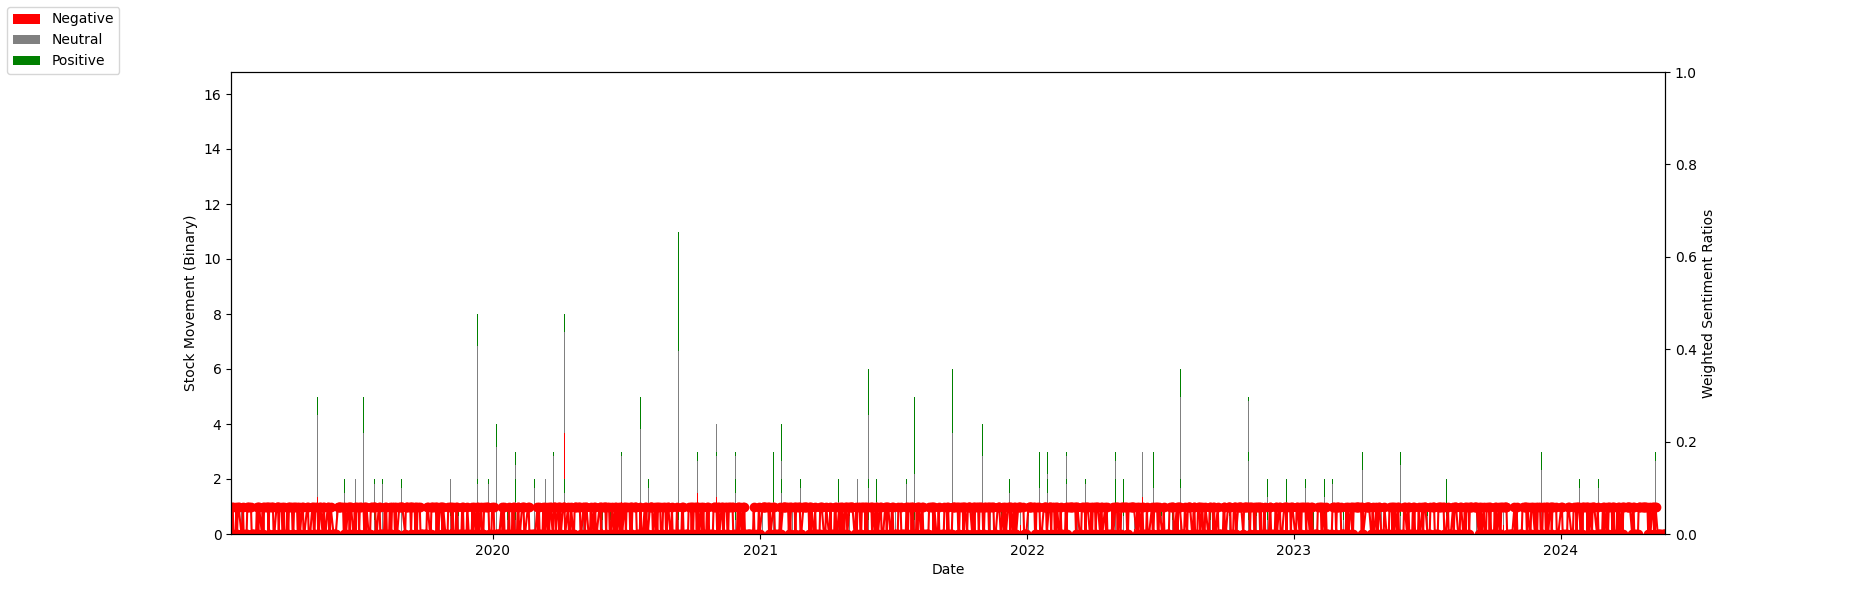

In [29]:
# Visualize Example Stock Price Movements (Up/Down) with Article Counts
%matplotlib ipympl
tz = pytz.timezone('America/New_York')

fig, ax1 = plt.subplots()
fig.set_size_inches(18.5, 6, forward=True)

tolerance = 2  # points

ret_binary = ret_df['CVX'].apply(lambda x: 1 if x > 0.0 else 0)

ax1.plot(ret_df.index, ret_binary, 'ro-', picker=tolerance)

# Calculate weighted values
dates = df_merged['Date']
weights = {
    "Negative": (df_merged['Neg_ratio_avg'] * df_merged['article_count']).tolist(),
    "Neutral": (df_merged['Neu_ratio_avg'] * df_merged['article_count']).tolist(),
    "Positive": (df_merged['Pos_ratio_avg'] * df_merged['article_count']).tolist()
}

colors = {
    "Negative": 'red',
    "Neutral": 'gray',
    "Positive": 'green'
}

ax2 = ax1.twinx()

width = 0.1
bottom = np.zeros(len(dates))

for sentiment, weight in weights.items():
    p = ax1.bar(dates, weight, width, label=sentiment, bottom=bottom, color=colors[sentiment])
    bottom += weight

ax1.set_xlim(left=ret_df.index.min(), right=ret_df.index.max())
ax2.set_xlim(left=ret_df.index.min(), right=ret_df.index.max())

# Add labels and legend
ax1.set_xlabel('Date')
ax1.set_ylabel('Stock Movement (Binary)')
ax2.set_ylabel('Weighted Sentiment Ratios')
fig.legend(loc='upper left')

plt.show()




def onclick(event):
    line = event.artist
    xdata, ydata = line.get_data()
    ind = event.ind
    datetime_obj  = xdata[ind][0].astype('datetime64[s]').astype(datetime)
    formatted_date = datetime_obj.strftime('%Y-%m-%d')
    print(formatted_date)
    #query = 'summarize the top news articles for chevron?'
    #top_results = 3
    #print(textwrap.fill(ask_vector_query(query, top_results, date=str(formatted_date), pinecone_index = "newsembedding3"), width=80))

#cid = fig.canvas.mpl_connect('button_press_event', onclick)
cid = fig.canvas.mpl_connect('pick_event', onclick)

In [30]:
# prep data for modeling
df_merged_drop = df_merged.drop(['Returns','Returns Next Day', 'Returns Next Day(no NaN)'], axis=1)
df_dropna = df_merged_drop.dropna()

# Convert the 'Date' column to datetime
df_dropna['Date'] = pd.to_datetime(df_dropna['Date'])

# Define the split date
base_date = pd.to_datetime('2021-01-01')
split_date = pd.to_datetime('2023-01-01')

# Split the DataFrame
train_df = df_dropna[(df_dropna['Date'] < split_date) & (df_dropna['Date'] >= base_date)]
test_df = df_dropna[df_dropna['Date'] >= split_date]

# define input variables
X_train_df = train_df.drop(columns=['Date','Ticker','Returns (no NaN)'])
X_test_df = test_df.drop(columns=['Date','Ticker','Returns (no NaN)'])

# define target variable
y_train_df = train_df['Returns (no NaN)'].apply(lambda x: 1 if x > 0.0 else 0)
y_test_df = test_df['Returns (no NaN)'].apply(lambda x: 1 if x > 0.0 else 0)

# Split the dataset into training and test sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# If you need to separate features and labels
X_train = X_train_df
y_train = y_train_df

X_test = X_test_df
y_test = y_test_df

print(len(X_train), len(y_train), len(X_test), len(y_test))

2877 2877 1820 1820


<ipython-input-30-4cd38e46816d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dropna['Date'] = pd.to_datetime(df_dropna['Date'])


Prep Data, Test and Train LSTM Model

<ipython-input-31-0f76e78aa0cd>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dropna['Date'] = pd.to_datetime(df_dropna['Date'])


Epoch 1/50
36/36 - 2s - loss: 0.6926 - accuracy: 0.5241 - val_loss: 0.6853 - val_accuracy: 0.5851 - 2s/epoch - 42ms/step
Epoch 2/50
36/36 - 0s - loss: 0.6914 - accuracy: 0.5250 - val_loss: 0.6844 - val_accuracy: 0.5903 - 120ms/epoch - 3ms/step
Epoch 3/50
36/36 - 0s - loss: 0.6897 - accuracy: 0.5285 - val_loss: 0.6850 - val_accuracy: 0.5955 - 115ms/epoch - 3ms/step
Epoch 4/50
36/36 - 0s - loss: 0.6894 - accuracy: 0.5458 - val_loss: 0.6836 - val_accuracy: 0.5955 - 119ms/epoch - 3ms/step
Epoch 5/50
36/36 - 0s - loss: 0.6894 - accuracy: 0.5298 - val_loss: 0.6851 - val_accuracy: 0.5903 - 117ms/epoch - 3ms/step
Epoch 6/50
36/36 - 0s - loss: 0.6889 - accuracy: 0.5298 - val_loss: 0.6841 - val_accuracy: 0.5903 - 117ms/epoch - 3ms/step
Epoch 7/50
36/36 - 0s - loss: 0.6881 - accuracy: 0.5324 - val_loss: 0.6845 - val_accuracy: 0.5851 - 137ms/epoch - 4ms/step
Epoch 8/50
36/36 - 0s - loss: 0.6872 - accuracy: 0.5411 - val_loss: 0.6860 - val_accuracy: 0.5816 - 116ms/epoch - 3ms/step
Epoch 9/50
36/36 -

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


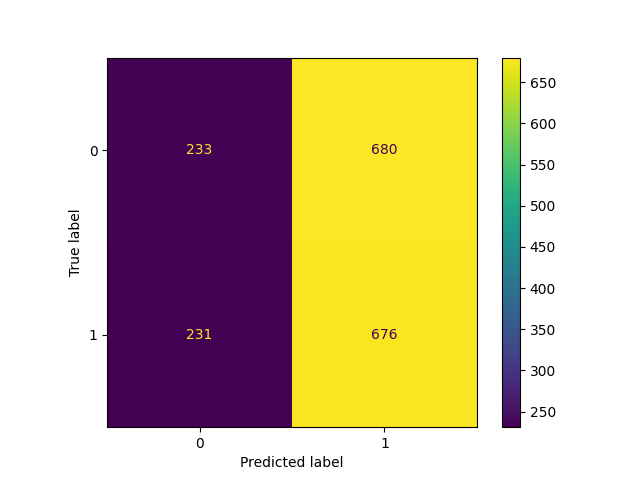

In [31]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Prep data for modeling
df_merged_drop = df_merged.drop(['Returns','Returns Next Day', 'Returns Next Day(no NaN)'], axis=1)
df_dropna = df_merged_drop.dropna()

# Convert the 'Date' column to datetime
df_dropna['Date'] = pd.to_datetime(df_dropna['Date'])

# Define the split date
base_date = pd.to_datetime('2021-01-01')
split_date = pd.to_datetime('2023-01-01')

# Split the DataFrame
train_df = df_dropna[(df_dropna['Date'] < split_date) & (df_dropna['Date'] >= base_date)]
test_df = df_dropna[df_dropna['Date'] >= split_date]

# Define input variables
X_train_df = train_df.drop(columns=['Date','Ticker','Returns (no NaN)'])
X_test_df = test_df.drop(columns=['Date','Ticker','Returns (no NaN)'])

# Define target variable
y_train_df = train_df['Returns (no NaN)'].apply(lambda x: 1 if x > 0.0 else 0)
y_test_df = test_df['Returns (no NaN)'].apply(lambda x: 1 if x > 0.0 else 0)

# If you need to separate features and labels
X_train = X_train_df.values
y_train = y_train_df.values

X_test = X_test_df.values
y_test = y_test_df.values

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape the data for LSTM (samples, timesteps, features)
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Define the LSTM model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))  # Use sigmoid activation for binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=64, validation_split=0.2, verbose=2)

# Make predictions on the test set
y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary predictions

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()

# Optional: Save the model
model.save('lstm_model.h5')

print(len(X_train), len(y_train), len(X_test), len(y_test))